필수
- 데이터프레임 결측치와 데이터 타입 확인 및 처리<br>
- 레그플롯과 박스 플롯을 통한 이상치 확인<br>
- 기술통계 및 도수분포표를 통한 이상치 확인 및 제거<br>
- 이상치 제거 후 레그플롯으로 확인<br>
- 스케일링 전 신뢰구간 확인 후 시각화<br>
- 정규분포가정(정규성 검정 대체)<br>
- 표준화-정규화(scaling)<br>
- 주성분 분석(PCA)<br>
- 상관분석<br>
- 회귀분석<br>
- 분석 결과 그래프 및 차트 제시

사용할 분석방법 후보
- 피어슨 상관분석, 회귀분석(단순회귀,다중회귀), 로지스틱 등

귀무가설: 총생활비와 y값의 상관이 없다.<br>
대립가설: 총생활비는 y값과 상관이 있다.

패키지 준비

In [2]:
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency,t
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas import read_excel, DataFrame, merge, cut
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA   # 주성분 분석용 패키지
from matplotlib import pyplot as plt
from patsy import dmatrix
from scipy import stats
from math import sqrt
from pca import pca # 주성분 분석 결과를 DataFrame으로 확인할 수 있는 기능을 제공하는 패키지

import statsmodels.api as sm
import seaborn as sb
import numpy as np
import helper
import sys
import os

그래프 초기화

In [3]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

# #데이터 준비

In [6]:
# 데이터 준비
df=read_excel("세미프로젝트3.xlsx")
df.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,집의_가격,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
0,275,0.0,0,7.0,0.0,10000,0,0.0,0,885.0,100000.0,92,0.0,13.0,360.0
1,239,0.0,0,7.0,0.0,0,0,0.0,0,2884.0,500.0,33,0.0,3.0,10.0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540,2544.0,40000.0,73,0.0,0.0,285.0
3,541,140.0,0,9.0,0.0,0,0,0.0,0,5783.0,70000.0,92,0.0,0.0,20.0
4,85,50.0,0,7.0,0.0,0,0,0.0,0,1192.0,NaN,46,0.0,7.0,3.0


In [11]:
#원본 데이터 유지하기 위해 카피본 생성
df1=df.copy()

df1 = df1.drop('집의_가격', axis=1)
df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
0,275,0.0,0,7.0,0.0,10000,0,0.0,0,885.0,92,0.0,13.0,360.0
1,239,0.0,0,7.0,0.0,0,0,0.0,0,2884.0,33,0.0,3.0,10.0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540,2544.0,73,0.0,0.0,285.0
3,541,140.0,0,9.0,0.0,0,0,0.0,0,5783.0,92,0.0,0.0,20.0
4,85,50.0,0,7.0,0.0,0,0,0.0,0,1192.0,46,0.0,7.0,3.0


In [12]:
#각 변수 데이터타입 확인하기
helper.prettyPrint(df1.dtypes, title='데이터 타입')

+----------------------+---------------+
|                      | 데이터 타입   |
|----------------------+---------------|
| 총생활비             | int64         |
| 이자_배당금_연간소득 | float64       |
| 임대료_연간소득      | int64         |
| 기타_소득            | float64       |
| 세금환급금           | float64       |
| 금융기관대출         | int64         |
| 주거관련_부채의_이자 | int64         |
| 주택관련_부채액      | float64       |
| 공적연금_연간소득    | int64         |
| 경상소득             | float64       |
| 주거면적             | int64         |
| 부모_송금보조비      | float64       |
| 자녀_송금보조비      | float64       |
| 민간보조금           | float64       |
+----------------------+---------------+


category 형식이 없음을 확인 - PCA에 적합할 것으로 판단.

for문으로 컬럼 돌려서 수치가 0인 값 갯수 확인

In [13]:
for column in df1.columns:
    zero_count = df1.loc[df1[column] == 0].shape[0]
    number_count = df1.loc[df1[column] != 0].shape[0]
    print('0 개수 :',{column : zero_count})
    # print('0 아닌 수 :',{column : number_count})
    print('-'*30)

0 개수 : {'총생활비': 0}
------------------------------
0 개수 : {'이자_배당금_연간소득': 5489}
------------------------------
0 개수 : {'임대료_연간소득': 6707}
------------------------------
0 개수 : {'기타_소득': 1439}
------------------------------
0 개수 : {'세금환급금': 6275}
------------------------------
0 개수 : {'금융기관대출': 5500}
------------------------------
0 개수 : {'주거관련_부채의_이자': 6414}
------------------------------
0 개수 : {'주택관련_부채액': 5342}
------------------------------
0 개수 : {'공적연금_연간소득': 4777}
------------------------------
0 개수 : {'경상소득': 0}
------------------------------
0 개수 : {'주거면적': 0}
------------------------------
0 개수 : {'부모_송금보조비': 5586}
------------------------------
0 개수 : {'자녀_송금보조비': 5146}
------------------------------
0 개수 : {'민간보조금': 4019}
------------------------------


## #이상치/결측치 확인 및 처리

- 종속변수
    - 총생활비

- 독립변수
    - '이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금'
    - '금융기관대출', '주거관련_부채의_이자','주택관련_부채액','공적연금_연간소득'

- 불로소득에 포함되는 변수
    - 이자_배당금_연간소득, 임대료_연간소득, 공적연금_연간소득,세금환급금

- 부채에 포함되는 변수
    - 금융기관대출, 주거관련_부채의_이자, 주택관련_부채액

In [14]:
df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
0,275,0.0,0,7.0,0.0,10000,0,0.0,0,885.0,92,0.0,13.0,360.0
1,239,0.0,0,7.0,0.0,0,0,0.0,0,2884.0,33,0.0,3.0,10.0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540,2544.0,73,0.0,0.0,285.0
3,541,140.0,0,9.0,0.0,0,0,0.0,0,5783.0,92,0.0,0.0,20.0
4,85,50.0,0,7.0,0.0,0,0,0.0,0,1192.0,46,0.0,7.0,3.0


In [15]:
# 결측치 확인(info를 사용해 데이터 수, 결측치 수를 확인할 수 있음)
na = df1.isna().sum()
helper.prettyPrint(na, title='결측치 수')

+----------------------+-------------+
|                      |   결측치 수 |
|----------------------+-------------|
| 총생활비             |           0 |
| 이자_배당금_연간소득 |           0 |
| 임대료_연간소득      |           0 |
| 기타_소득            |           0 |
| 세금환급금           |           0 |
| 금융기관대출         |           0 |
| 주거관련_부채의_이자 |           0 |
| 주택관련_부채액      |        1079 |
| 공적연금_연간소득    |           0 |
| 경상소득             |           0 |
| 주거면적             |           0 |
| 부모_송금보조비      |           0 |
| 자녀_송금보조비      |           0 |
| 민간보조금           |           0 |
+----------------------+-------------+


주택관련_부채액 결측치 1079건의 데이터 값을 '0'으로 간주하고 대체

집의 가격의 중앙값으로 대체

In [16]:
# # 주택관련_부채액에 0 값 채우기
# re_df1 = df1.fillna({'주택관련_부채액': 0})
re_df1 = df1.copy()
median_price1 = re_df1['주택관련_부채액'].median()
re_df1['주택관련_부채액'].fillna(median_price1, inplace=True)
# 집의 가격에 중간값(median) 채우기
median_price2 = re_df1['집의_가격'].median()
re_df1['집의_가격'].fillna(median_price2, inplace=True)
re_df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
0,275,0.0,0,7.0,0.0,10000,0,0.0,0,885.0,92,0.0,13.0,360.0
1,239,0.0,0,7.0,0.0,0,0,0.0,0,2884.0,33,0.0,3.0,10.0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540,2544.0,73,0.0,0.0,285.0
3,541,140.0,0,9.0,0.0,0,0,0.0,0,5783.0,92,0.0,0.0,20.0
4,85,50.0,0,7.0,0.0,0,0,0.0,0,1192.0,46,0.0,7.0,3.0


결측치 수정 확인

In [75]:
helper.prettyPrint(re_df1.isna().sum(), title='결측치 수')

+----------------------+-------------+
|                      |   결측치 수 |
|----------------------+-------------|
| 총생활비             |           0 |
| 이자_배당금_연간소득 |           0 |
| 임대료_연간소득      |           0 |
| 기타_소득            |           0 |
| 세금환급금           |           0 |
| 금융기관대출         |           0 |
| 주거관련_부채의_이자 |           0 |
| 주택관련_부채액      |           0 |
| 공적연금_연간소득    |           0 |
| 경상소득             |           0 |
| 집의_가격            |           0 |
| 주거면적             |           0 |
| 부모_송금보조비      |           0 |
| 자녀_송금보조비      |           0 |
| 민간보조금           |           0 |
+----------------------+-------------+


## #기초통계량으로 데이터의 전체적 특징 확인

In [76]:
re_df1.describe().round(3)

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,집의_가격,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
count,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000,7865.000
mean,329.822,55.538,129.336,8.456,14.506,2958.797,53.392,1773.448,288.639,4535.450,21052.366,77.954,6.034,7.195,58.166
std,1314.994,347.927,644.463,87.830,59.831,8277.347,195.466,5527.462,675.031,4342.727,29993.409,30.231,19.318,37.040,202.689
min,23.000,0.000,0.000,0.000,-700.000,0.000,0.000,0.000,0.000,-11831.000,0.000,7.000,0.000,0.000,0.000
25%,121.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1520.000,5000.000,56.000,0.000,0.000,0.000
50%,228.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000,0.000,3135.000,12000.000,79.000,0.000,0.000,0.000
75%,435.000,20.000,0.000,8.000,0.000,1700.000,0.000,0.000,288.000,6413.000,25000.000,99.000,4.000,4.000,30.000
max,114446.000,22025.000,17640.000,5506.000,1000.000,200000.000,7200.000,120000.000,8796.000,110210.000,650000.000,327.000,800.000,2104.000,4555.000


확인 결과 각 컬럼별 평균치에 비해 max값이 비정상적으로 높은 수치가 존재함을 확인.

이상치가 존재할 수 있다고 판단할 수도 있다.

# #전처리1. 종속/독립변수의 이상치 확인

컬럼 별 이상치 찾기(1)

보기 쉽게 sub plot 및 for문 이용해서 한 번에 regplot 그래프 시각화

In [77]:
# 그래프 생성을 위해 컬럼 이름, 길이 확인
re_df1.head()
re_df1.columns
len(re_df1.columns)

15

In [78]:
len(list(re_df1.columns)[1:])

14

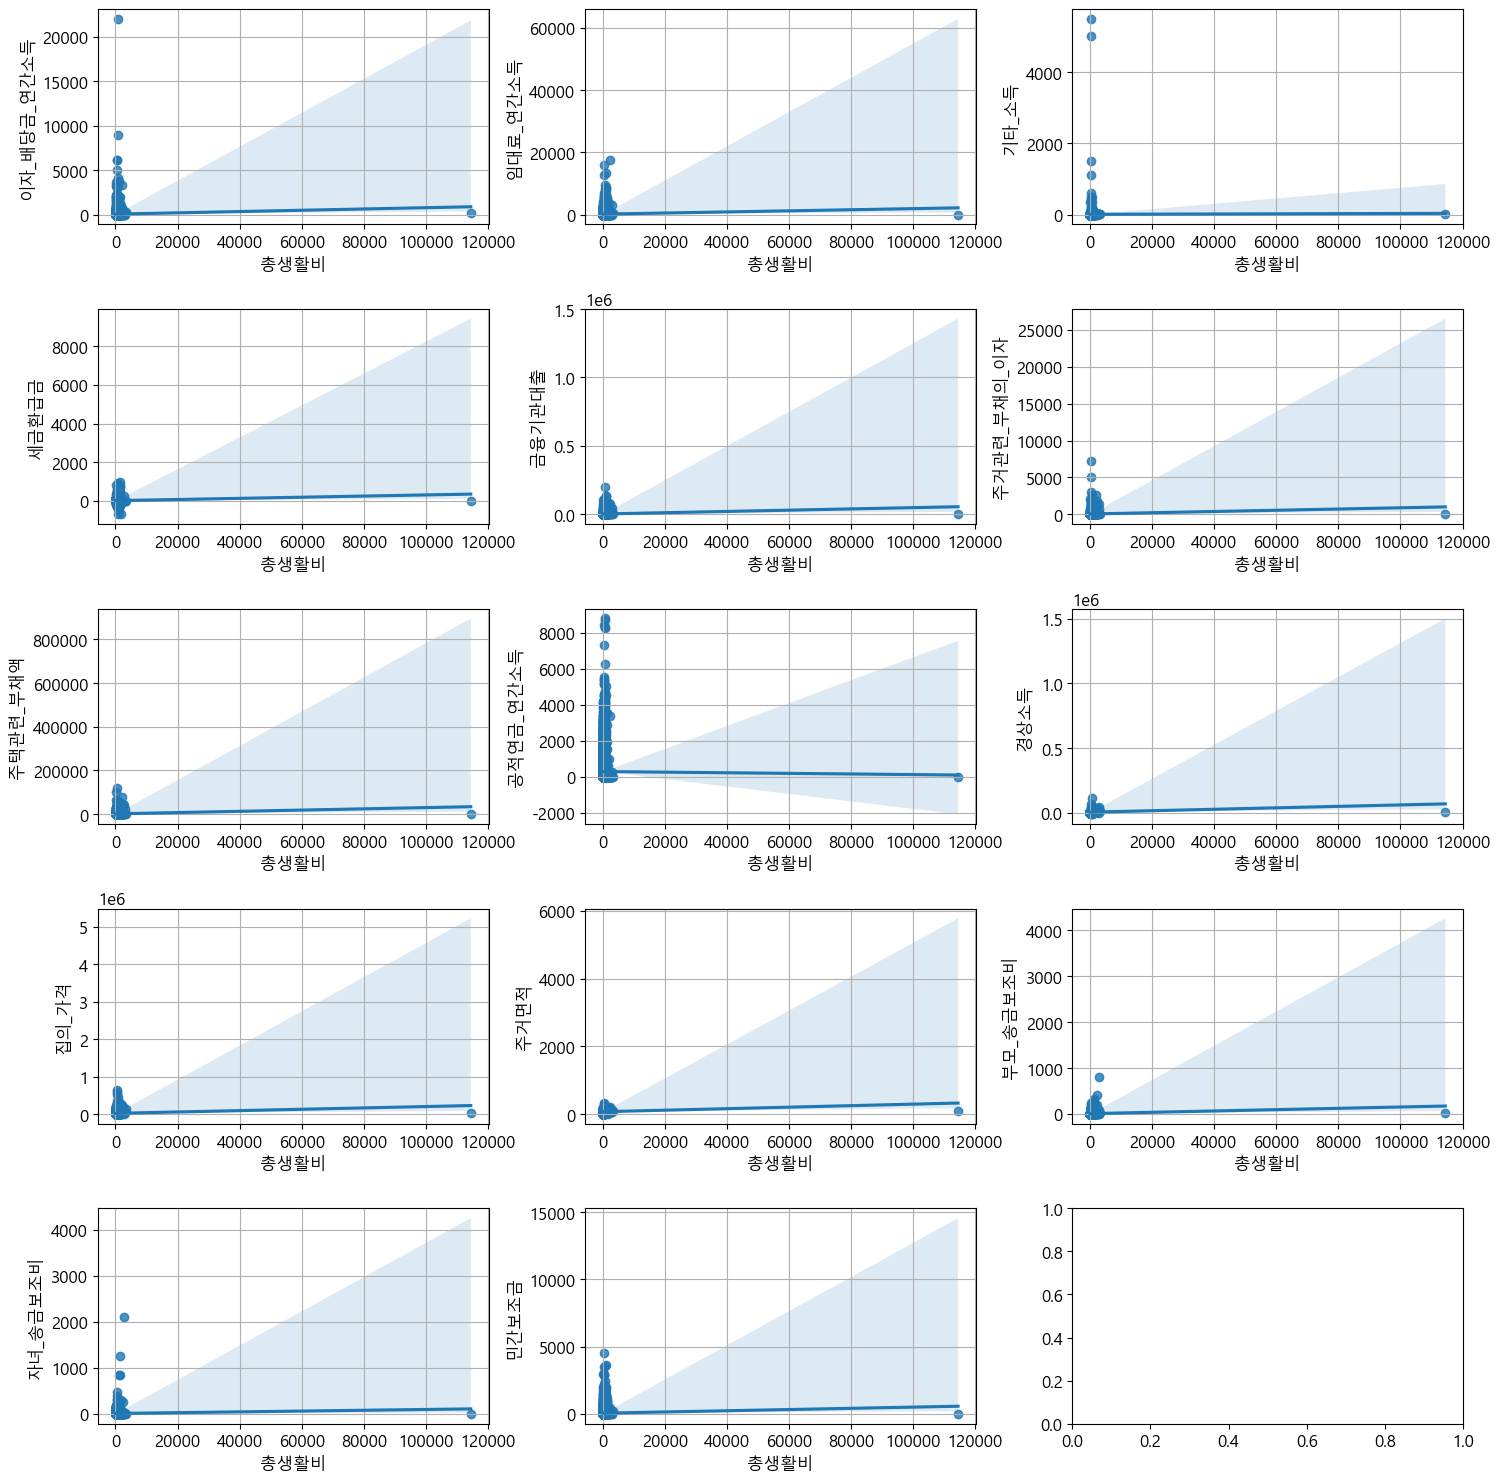

In [79]:
# re_df1은 결측치 처리한 값
columns = list(re_df1.columns)[1:]

# 4행 3열로 서브플롯 그래프 그리기
fig, ax = plt.subplots(5, 3, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 3)  # 3열로 설정
    sb.regplot(data=re_df1, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid(True)

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

컬럼 별 이상치 찾기(2)

보기 쉽게 sub plot 및 for문 이용해서 한 번에 boxplot 그래프 조회 

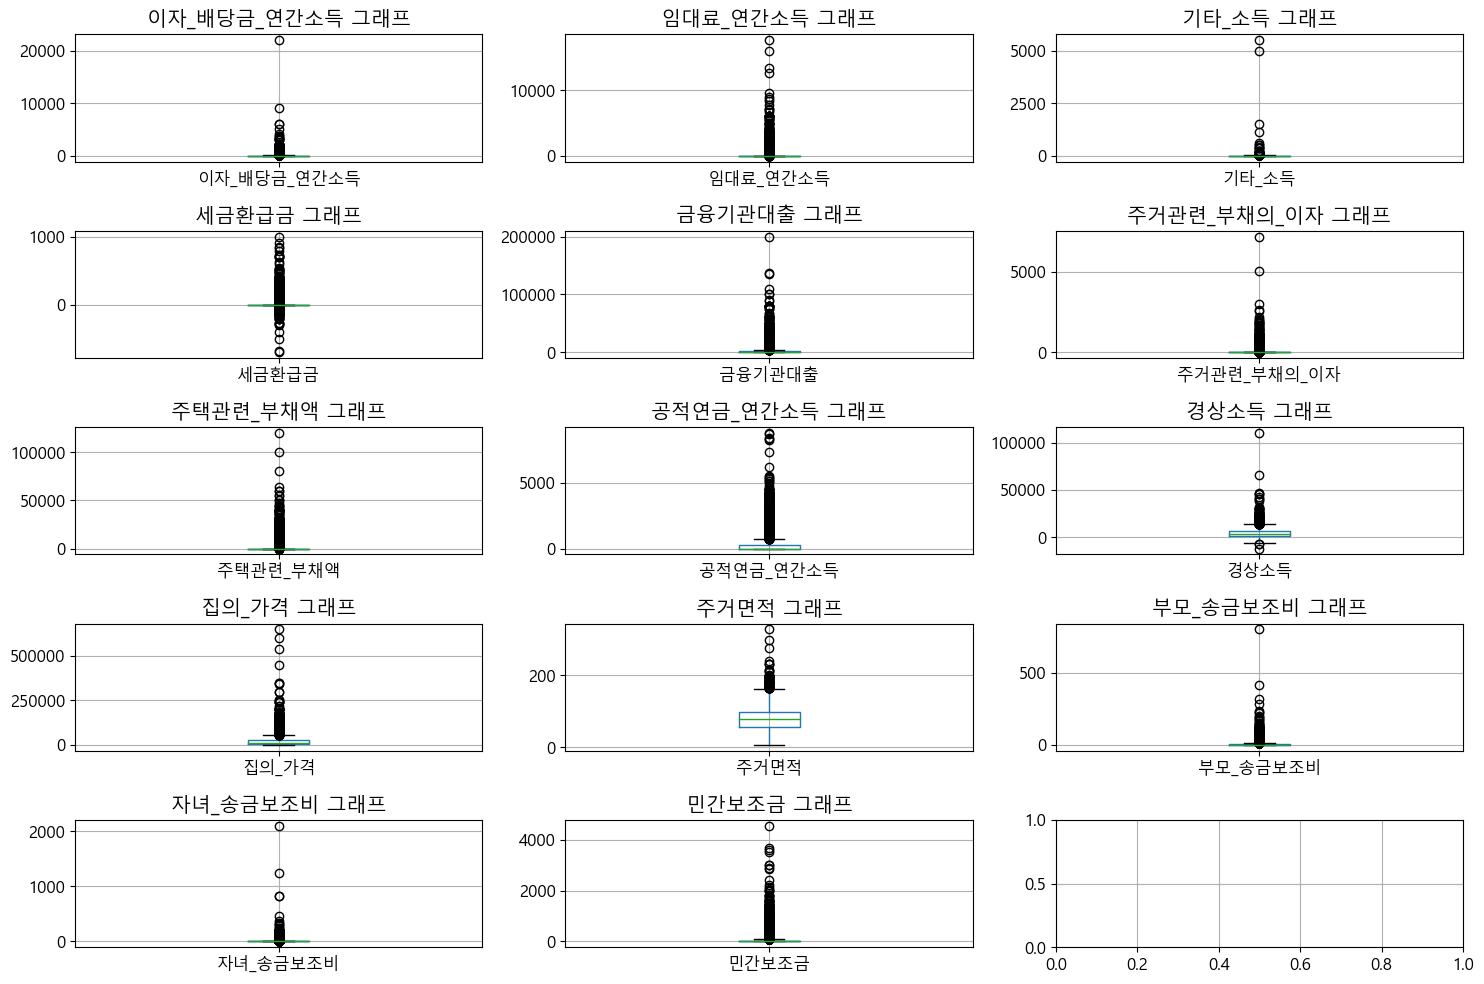

In [80]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
for i, c in enumerate(columns):
    row, col = divmod(i, 3)
    re_df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid(True)
plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

In [81]:
# # des_df를 만들고 결측치 처리한 DF인 're_df1'로 기초통계량 확인 
# des_df = re_df1.describe()
# des_df.head().round(3)

regplot, boxplot 조회 결과

- x값으로 넣을 종속변수(총생활비)에서 1건만 비정상으로 높은 수치 확인되어 제거하고 진행

- y값으로 넣을 독립변수들 중 이상치가 각 컬럼에서 발견되어 프로젝트 참가자들 주관적 판단에 의해 제거하기로 결정

- 컬럼별 제거 데이터 
     - 이자_배당금_연간소득 상위이상치 2건
     - 임대료_연간소득 상위이상치 4건
     - 기타_소득 상위이상치 4건
     - 주택관련_부채액 상위이상치 3건
     - 공적연금_연간소득 상위이상치 7건
     - 세금환급금 상위이상치 8건
     - 금융기관대출 상위이상치 2건
     - 주거관련_부채의_이자 상위이상치 4건

- 종속변수,독립변수 포함해서 총35건의 데이터 제거하였음

이상치 행 제외 후 데이터 재조회

In [82]:
# re_df1.columns

In [83]:
#  #   and (집의_가격 < 200000) 
# df2=re_df1.query('(총생활비 < 5000) and (이자_배당금_연간소득 < 10000) and (임대료_연간소득 < 10000) and\
#                  (기타_소득 < 1000) and (세금환급금 > -500 and 세금환급금 < 750) and (금융기관대출 < 100000) and\
#                  (주거관련_부채의_이자 < 3000) and(주택관련_부채액 <75000) and (공적연금_연간소득 < 6000) and\
#                  (경상소득 < 50000) and ()')
# df2

시각화를 통한 이상치 제거 후 데이터 확인

In [84]:
# # 결측치를 처리한 후 시각화
# # re_df1은 결측치 처리한 값
# columns = list(df2.columns)[1:]

# # 4행 3열로 서브플롯 그래프 그리기
# fig, ax = plt.subplots(5, 3, figsize=(15, 15))

# # 종속변수 설정
# dependent_variable = '총생활비'

# for i, c in enumerate(columns):
#     row, col = divmod(i, 3)  # 3열로 설정
#     sb.regplot(data=re_df1, x=dependent_variable, y=c, ax=ax[row, col])
#     ax[row, col].set_xlabel(dependent_variable)
#     ax[row, col].set_ylabel(c)
#     ax[row, col].grid(True)

# plt.tight_layout()  # 서브플롯 간격 조정
# plt.show()

In [85]:
# #데이터 분포가 이전보다 나아졌는지 히스토그램 그래프로 재확인

# num_bins = 15  # 히스토그램 구간 개수
# fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))  # 3x3 서브플롯 생성

# for ax, column in zip(ax.flat, df2.columns):
#     hist, bins = np.histogram(df2[column], bins=num_bins)
#     bins2 = np.round(bins, 1)

#     sb.histplot(data=df2, x=column, bins=num_bins, kde=False, ax=ax)
#     ax.set_title(column)  # 각 subplot의 제목 설정
#     ax.set_xticks(bins2)  # x축 눈금 설정
#     ax.set_xticklabels(bins2, rotation=45, fontsize=10)  # x축 눈금 라벨 설정 (각도 45도)
#     ax.yaxis.set_tick_params(labelsize=10) #y축 폰트 사이즈 설정
#     ax.grid(True)

# plt.tight_layout()  # 서브플롯 간격 조정
# plt.show()

이상치는 어느정도 해결했지만 0에 치우친 값이 상당히 많음을 확인.

결측치를 0으로 상정하고 처리한 만큼 분석에 유의할 것

In [86]:
# des_df2 = df2.describe().round(3)
# des_df2

피어슨 상관분석 통해 상관계수와 p-value값 확인하기

In [87]:
# tmp_df2 = df2.drop('총생활비', axis=1)
# # tmp_df2
# pearson_r(tmp_df2)
# corr = tmp_df2.corr(method='pearson')
# plt.rcParams["figure.figsize"] = (6,3)
# plt.rcParams['font.size'] = 8
# sb.heatmap(tmp_df2.corr(method='pearson'), annot = True, cmap = 'Greens', vmin = -1, vmax=1, linewidths=.5)
# plt.show()
# plt.close()

피어슨 상관분석 통해 상관계수와 p-value값 확인하기

In [88]:
# spearman_r(tmp_df2)
# corr = tmp_df2.corr(method='spearman')
# plt.rcParams["figure.figsize"] = (6,3)
# plt.rcParams['font.size'] = 8
# sb.heatmap(tmp_df2.corr(method='pearson'), annot = True, cmap = 'Greens', vmin = -1, vmax=1, linewidths=.5)
# plt.show()
# plt.close()

상관계수 행렬 생성 후 산점도 행렬 시각화

그래프와 피어슨 상관분석을 바탕으로 총생활비(=소비금액) 금액이 커질수록 불로소득(이자_배당금_연간소득, 임대료_연간소득, 세금환급금)이 `양의 상관관계`를 가진다고 예측할 수 있다.

다만, `공적연금_연간소득`과는 상관관계가 크지 않다고 판단이 된다.

# #전처리2. 정규성/등분산성/독립성 확인

비모수적인 방법 사용, 로버스트(robust) 통계 기법 사용, 대규모 데이터셋 사용, 통계 기법과 목적에 따른 유연성(회귀분석의 예측 모델링이 목적)에 따라 정규성/등분산성/독립성 확인을 제외

현재 대규모 데이터셋을 사용하기 때문에 정규성, 등분산성, 독립성 확인은 제외하기로 결정

#선형회귀->정규분포 가정으로 대체를 해야하는지 확인해보기

신뢰구간

In [89]:
# 정규화 하기 전 각 컬럼의 신뢰구간 구하기
# df2Col = list(df2.columns)
# # df2Col
# for cc in df2Col:
#     print("%s 신뢰구간"%cc)
#     getConfidenceInterval(df2["%s"%cc])
#     # print('\n')

re_df1
df1Col = list(re_df1.columns)
# df2Col
for cc in df1Col:
    print("%s 신뢰구간"%cc)
    helper.getConfidenceInterval(re_df1["%s"%cc])
    # print('\n')

총생활비 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    300.755 |
| 상한 |    358.888 |
+------+------------+
이자_배당금_연간소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    47.8474 |
| 상한 |    63.2284 |
+------+------------+
임대료_연간소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    115.091 |
| 상한 |    143.581 |
+------+------------+
기타_소득 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    6.51454 |
| 상한 |    10.3973 |
+------+------------+
세금환급금 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    13.1835 |
| 상한 |    15.8285 |
+------+------------+
금융기관대출 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    2775.84 |
| 상한 |    3141.76 |
+------+------------+
주거관련_부채의_이자 신뢰구간
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    49.0712 |
| 상한 |    57.7123 |
+------+------------+
주택관련_부채액 신뢰구간
+------+------------+
|   

# #전처리3. 표준화-정규화(Scaling)

표준화(정규화)를 통해 서로 다른 단위나 범위를 가진 데이터를 동일한 기준으로 맞춤으로써, 데이터 분석이나 머신러닝 모델의 성능을 향상.

다만, 현재 사용중인 데이터에는 명목형(범주형)변수를 제외한 경우인 만큼 더미변수화 시킬 필요가 없다고 판단, 스케일링만 진행하기로 결정.

시간이 된다면 (표준화 적용한 결과/표준화를 적용하지 않은 결과의 차이를 비교, 학습)

데이터 정규화하기

In [90]:
scaler=StandardScaler()
# df_std = df2.copy()
df_std = re_df1.copy()

df_std['총생활비'] = scaler.fit_transform(df_std[['총생활비']])
df_std['이자_배당금_연간소득'] = scaler.fit_transform(df_std[['이자_배당금_연간소득']])
df_std['임대료_연간소득'] = scaler.fit_transform(df_std[['임대료_연간소득']])
df_std['기타_소득'] = scaler.fit_transform(df_std[['기타_소득']])
df_std['세금환급금'] = scaler.fit_transform(df_std[['세금환급금']])
df_std['금융기관대출'] = scaler.fit_transform(df_std[['금융기관대출']])
df_std['주거관련_부채의_이자'] = scaler.fit_transform(df_std[['주거관련_부채의_이자']])
df_std['주택관련_부채액'] = scaler.fit_transform(df_std[['주택관련_부채액']])
df_std['공적연금_연간소득'] = scaler.fit_transform(df_std[['공적연금_연간소득']])
df_std

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,집의_가격,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
0,-0.041692,-0.159635,-0.200700,-0.016577,-0.242466,0.850713,-0.273168,-0.320863,-0.427620,885.0,100000.0,92,0.0,13.0,360.0
1,-0.069071,-0.159635,-0.200700,-0.016577,-0.242466,-0.357480,-0.273168,-0.320863,-0.427620,2884.0,500.0,33,0.0,3.0,10.0
2,-0.132193,-0.159635,-0.076558,-0.016577,-0.242466,1.333991,3.410572,3.388127,0.372394,2544.0,40000.0,73,0.0,0.0,285.0
3,0.160603,0.242773,-0.200700,0.006195,-0.242466,-0.357480,-0.273168,-0.320863,-0.427620,5783.0,70000.0,92,0.0,0.0,20.0
4,-0.186189,-0.015918,-0.200700,-0.016577,-0.242466,-0.357480,-0.273168,-0.320863,-0.427620,1192.0,12000.0,46,0.0,7.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7860,0.041203,-0.159635,-0.200700,-0.084896,0.927577,0.004978,0.217997,0.221916,-0.427620,5503.0,27000.0,112,8.0,0.0,0.0
7861,0.292931,-0.159635,0.823474,-0.084896,1.261875,4.475293,-0.273168,-0.320863,-0.427620,10790.0,80000.0,112,33.0,0.0,0.0
7862,0.201670,-0.159635,6.006416,-0.084896,-0.242466,2.777419,0.069624,4.373633,-0.427620,10504.0,70000.0,112,25.0,0.0,0.0
7863,0.176574,-0.044661,-0.200700,-0.096282,-0.242466,1.092352,1.568702,1.850253,-0.427620,10420.0,30000.0,99,42.0,0.0,0.0


In [91]:
helper.prettyPrint(df_std.dtypes, title='데이터 타입')

+----------------------+---------------+
|                      | 데이터 타입   |
|----------------------+---------------|
| 총생활비             | float64       |
| 이자_배당금_연간소득 | float64       |
| 임대료_연간소득      | float64       |
| 기타_소득            | float64       |
| 세금환급금           | float64       |
| 금융기관대출         | float64       |
| 주거관련_부채의_이자 | float64       |
| 주택관련_부채액      | float64       |
| 공적연금_연간소득    | float64       |
| 경상소득             | float64       |
| 집의_가격            | float64       |
| 주거면적             | int64         |
| 부모_송금보조비      | float64       |
| 자녀_송금보조비      | float64       |
| 민간보조금           | float64       |
+----------------------+---------------+


category 데이터 없음

# #회귀분석

In [92]:
xColumn = []
for i in range(1,len(re_df1.columns)):
    xColumn.append(re_df1.columns[i])
ols_result = helper.myOls(re_df1, y='총생활비', x=xColumn)
ols_result.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총생활비   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     18.69
Date:                Fri, 11 Aug 2023   Prob (F-statistic):           7.71e-47
Time:                        14:11:27   Log-Likelihood:                -67514.
No. Observations:                7865   AIC:                         1.351e+05
Df Residuals:                    7850   BIC:                         1.352e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.6587     41.302     -0.089      0.929     -84.622      77.304
이자_배당금_연간소득    -0.0036      0.043     -0.085      0.932      -0.087       0.080
임대료_연간소득       -0.0086      0.024     -0.349      0.727      -0.057       0.039
기타_소득           0.0008      0.167      0.005      0.996      -0.326       0.327
세금환급금           0.0160      0.264      0.060      0.952      -0.502       0.534
금융기관대출          0.0011      0.002      0.459      0.646      -0.004       0.006
주거관련_부채의_이자    -0.0326      0.108     -0.302      0.762      -0.244       0.179
주택관련_부채액        0.0004      0.004      0.093      0.926      -0.008       0.009
공적연금_연간소득      -0.0252      0.023     -1.112      0.266      -0.070       0.019
경상소득            0.0407      0.004      9.522      0.000       0.032       0.049
집의_가격           0.0005      0.001      0.863      0.388      -0.001       0.002
주거면적            1.5346      0.564      2.720      0.007       0.429       2.641
부모_송금보조비        2.7536      0.828      3.326      0.001       1.131       4.377
자녀_송금보조비        0.7076      0.399      1.773      0.076      -0.075       1.490
민간보조금           0.0542      0.073      0.746      0.456      -0.088       0.197
==============================================================================
Omnibus:                    29932.464   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      19155917761.155
Skew:                          86.830   Prob(JB):                         0.00
Kurtosis:                    7646.560   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

결과보고

In [93]:
ols_result.table

print(ols_result.result, end="\n\n")
print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

𝑅(0.032), 𝑅^2(0.031), 𝐹(18.69), 유의확률(7.71e-47), Durbin-Watson(2.000)

총생활비에 대하여 이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,집의_가격,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(14,7850) = 18.69, p < 0.05).

이자_배당금_연간소득의 회귀계수는 -0.0036(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
임대료_연간소득의 회귀계수는 -0.0086(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
기타_소득의 회귀계수는 0.0008(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
세금환급금의 회귀계수는 0.0160(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
금융기관대출의 회귀계수는 0.0011(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
주거관련_부채의_이자의 회귀계수는 -0.0326(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
주택관련_부채액의 회귀계수는 0.0004(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
공적연금_연간소득의 회귀계수는 -0.0252(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
경상소득의 회귀계수는 0.0407(p<0.05)로, 총생활비에 대하여 유의미한 예측변인인 것으로 나타났다.
집의_가격의 회귀계수는 0.0005(p>0.05)로, 총생활비에 대하여 유의하지 않은 예측변인인 것으로 나타났다.
주거면적의 회귀계수는 1.5346(p<0.05)로, 총생활비에 대하여 유의미한 예측변인인 것으로 나타났다.
부모_송금보조비의 회귀계수는

# #잔차분석

결과치 생성

In [94]:
sdf = DataFrame({
    "관측값": re_df1['총생활비'],
    "예측값": ols_result.fit.fittedvalues,
    "잔차": ols_result.fit.resid,
    "zscore": stats.zscore(ols_result.fit.fittedvalues)
})
sdf

,관측값,예측값,잔차,zscore
0,275,263.715784,11.284216,-0.279915
1,239,167.207349,71.792651,-0.688565
2,156,233.552918,-77.552918,-0.407635
3,541,408.515108,132.484892,0.333216
4,85,126.388594,-41.388594,-0.861406
...,...,...,...,...
7860,384,430.201995,-46.201995,0.425045
7861,715,778.770532,-63.770532,1.901006
7862,595,702.611845,-107.611845,1.578524
7863,562,709.206777,-147.206777,1.606449


정규성 확인1 

Q-Q Plot

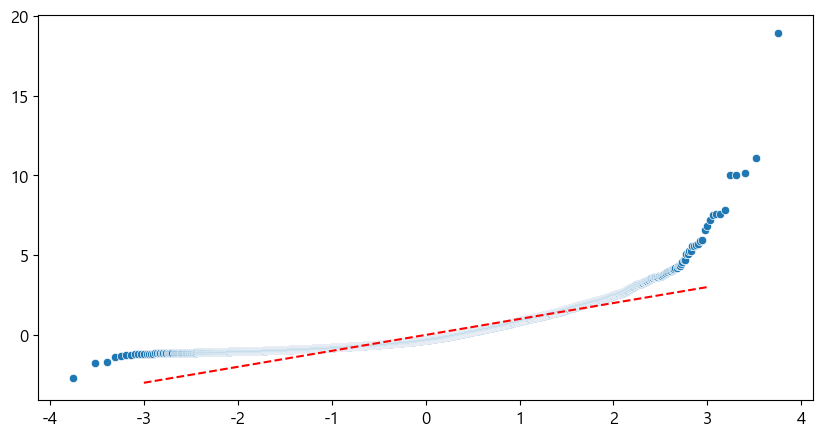

In [95]:
(x, y), _  = stats.probplot(sdf['zscore'])

plt.figure(figsize=(10,5))
sb.scatterplot(x=x, y=y)
sb.lineplot(x=[-3, 3], y=[-3, 3], color='red', linestyle='--')
plt.show()
plt.close()

정규성 판단2 

Kolmogorov Smirnov 검정

In [96]:
s, p = stats.kstest(sdf['잔차'], 'norm')
print("Kolmogorov Smirnov Test: (통계량, p-value) = ", (s, p))

if p > 0.05:
    print("잔차는 정규 분포를 따릅니다. (귀무가설 채택)")
else:
    print("잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)")

Kolmogorov Smirnov Test: (통계량, p-value) =  (0.6510400094870014, 0.0)
잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)


잔차의 등분산성 확인

브로이슈 패건 검정

In [97]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = het_breuschpagan(ols_result.fit.resid, ols_result.fit.model.exog)
DataFrame(test_result, index=names)

,0
Lagrange multiplier statistic,3.007393
p-value,0.999061
f-value,0.214486
f p-value,0.999066


boxplot1

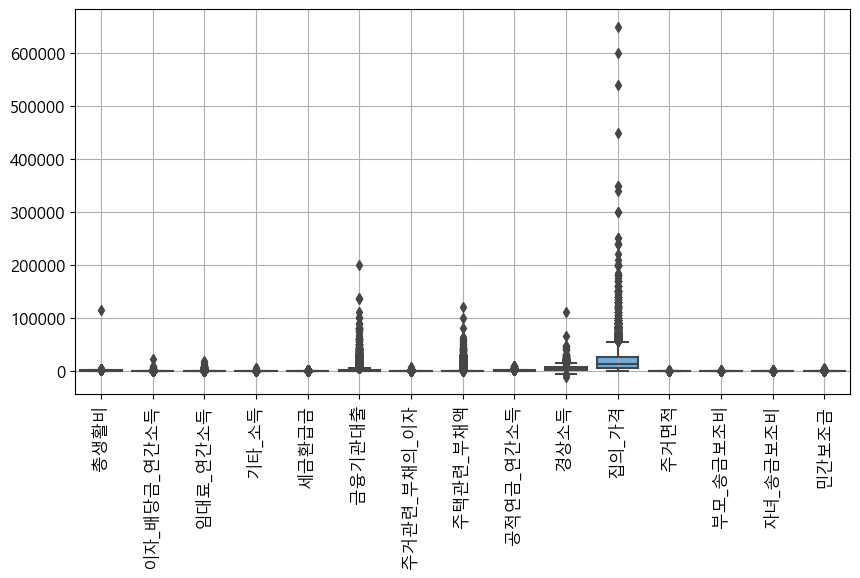

In [98]:
plt.figure()
sb.boxplot(data=re_df1)
plt.xticks(rotation=90)
plt.grid()
plt.show()
plt.close()

boxplot2

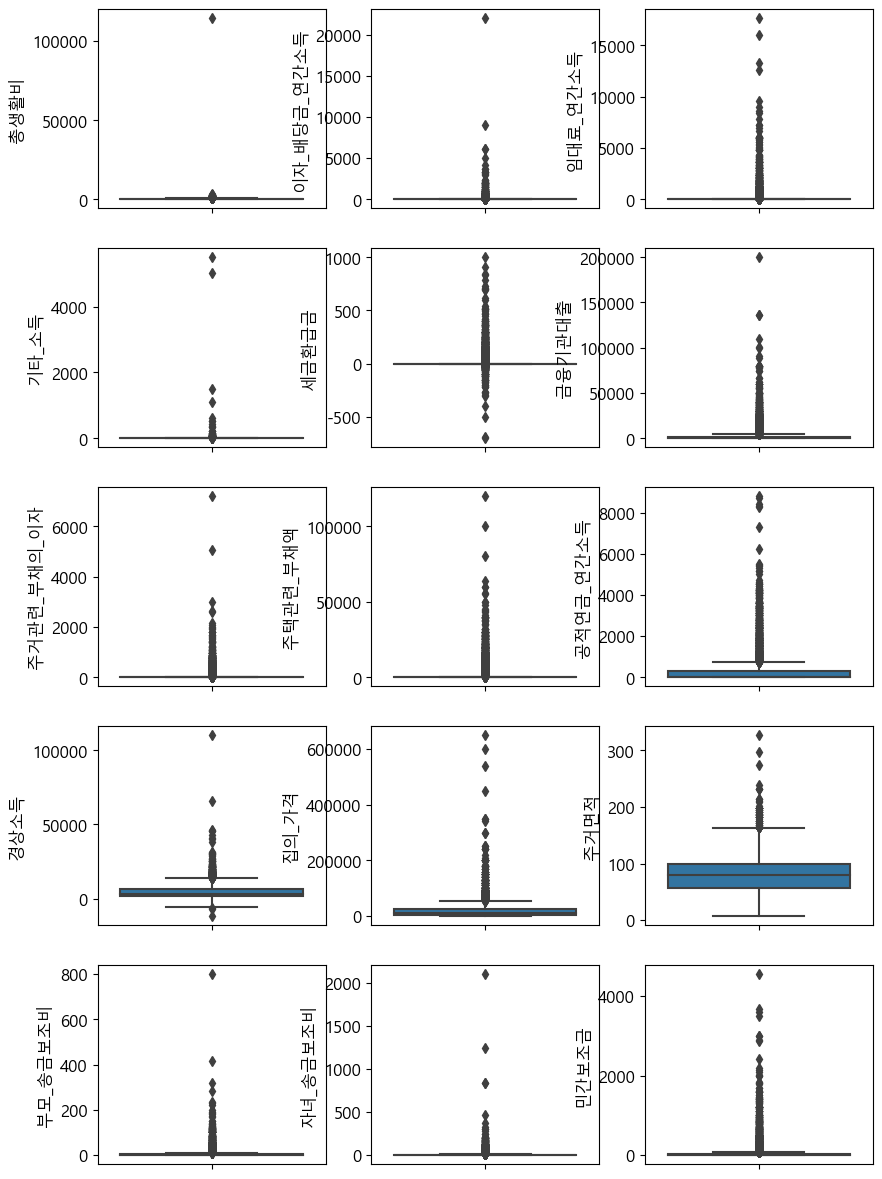

In [99]:
fig, ax = plt.subplots(5,3, figsize=(10,15))
rows = len(ax)
cols = len(ax[0])

for i in range(0, rows):
    for j in range(0, cols):
        idx = i*cols+j
        # print("idx=%d, i=%d, j=%d"%(idx,i,j))
        sb.boxplot(re_df1, y=re_df1.columns[idx], ax=ax[i][j])

        if idx+1 == len(re_df1.columns):
            break
plt.show()
plt.close()

PCA 분석

In [100]:
x_train_std = df_std.drop("총생활비", axis=1)
x_train_std

,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득,경상소득,집의_가격,주거면적,부모_송금보조비,자녀_송금보조비,민간보조금
0,-0.159635,-0.200700,-0.016577,-0.242466,0.850713,-0.273168,-0.320863,-0.427620,885.0,100000.0,92,0.0,13.0,360.0
1,-0.159635,-0.200700,-0.016577,-0.242466,-0.357480,-0.273168,-0.320863,-0.427620,2884.0,500.0,33,0.0,3.0,10.0
2,-0.159635,-0.076558,-0.016577,-0.242466,1.333991,3.410572,3.388127,0.372394,2544.0,40000.0,73,0.0,0.0,285.0
3,0.242773,-0.200700,0.006195,-0.242466,-0.357480,-0.273168,-0.320863,-0.427620,5783.0,70000.0,92,0.0,0.0,20.0
4,-0.015918,-0.200700,-0.016577,-0.242466,-0.357480,-0.273168,-0.320863,-0.427620,1192.0,12000.0,46,0.0,7.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7860,-0.159635,-0.200700,-0.084896,0.927577,0.004978,0.217997,0.221916,-0.427620,5503.0,27000.0,112,8.0,0.0,0.0
7861,-0.159635,0.823474,-0.084896,1.261875,4.475293,-0.273168,-0.320863,-0.427620,10790.0,80000.0,112,33.0,0.0,0.0
7862,-0.159635,6.006416,-0.084896,-0.242466,2.777419,0.069624,4.373633,-0.427620,10504.0,70000.0,112,25.0,0.0,0.0
7863,-0.044661,-0.200700,-0.096282,-0.242466,1.092352,1.568702,1.850253,-0.427620,10420.0,30000.0,99,42.0,0.0,0.0


In [101]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std)
topfeat = fit['topfeat']
topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [14] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [1] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [14] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[1]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,집의_가격,9.987241e-01,best
1,PC1,이자_배당금_연간소득,3.067225e-06,weak
2,PC1,임대료_연간소득,8.323751e-06,weak
3,PC1,기타_소득,5.289743e-07,weak
4,PC1,세금환급금,6.155688e-06,weak
5,PC1,금융기관대출,9.639297e-06,weak
6,PC1,주거관련_부채의_이자,9.618460e-06,weak
7,PC1,주택관련_부채액,1.163970e-05,weak
8,PC1,공적연금_연간소득,4.882058e-06,weak
9,PC1,경상소득,5.049760e-02,weak


주성분 설정

In [102]:
best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
best_names

['집의_가격']

In [103]:
# df2.columns[0]

In [104]:
target_names = best_names + ['총생활비']
target_names

['집의_가격', '총생활비']

In [105]:
df_new = df_std.filter(target_names)
df_new.head()

,집의_가격,총생활비
0,100000.0,-0.041692
1,500.0,-0.069071
2,40000.0,-0.132193
3,70000.0,0.160603
4,12000.0,-0.186189


회귀분석 진행

In [106]:
ols_result = helper.myOls(df_new, y='총생활비', x=best_names)
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                   총생활비   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     49.92
Date:                Fri, 11 Aug 2023   Prob (F-statistic):           1.74e-12
Time:                        14:11:31   Log-Likelihood:                -11135.
No. Observations:                7865   AIC:                         2.227e+04
Df Residuals:                    7863   BIC:                         2.229e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0558      0.014     -4.059      0.0

In [107]:
ols_result.table

,,B,표준오차,β,t,유의확률,VIF
종속변수,독립변수,,,,,,
총생활비,집의_가격,2.648e-06,3.75e-07,0,7.065*,0.000,1.004244


In [108]:
print(ols_result.result, end="\n\n")
print(ols_result.goodness, end="\n\n")
for i in ols_result.varstr:
    print(i)

𝑅(0.006), 𝑅^2(0.006), 𝐹(49.92), 유의확률(1.74e-12), Durbin-Watson(1.997)

총생활비에 대하여 집의_가격로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(1,7863) = 49.92, p < 0.05).

집의_가격의 회귀계수는 2.648e-06(p<0.05)로, 총생활비에 대하여 유의미한 예측변인인 것으로 나타났다.


결과표 생성

In [109]:
sdf = DataFrame({
    "관측값": df_new['총생활비'],
    "예측값": ols_result.fit.fittedvalues,
    "잔차": ols_result.fit.resid,
    "zscore": stats.zscore(ols_result.fit.fittedvalues)
})

sdf

,관측값,예측값,잔차,zscore
0,-0.041692,0.209081,-0.250773,2.632333
1,-0.069071,-0.054430,-0.014641,-0.685273
2,-0.132193,0.050180,-0.182373,0.631767
3,0.160603,0.129631,0.030972,1.632050
4,-0.186189,-0.023974,-0.162215,-0.301831
...,...,...,...,...
7860,0.041203,0.015751,0.025452,0.198311
7861,0.292931,0.156114,0.136817,1.965478
7862,0.201670,0.129631,0.072040,1.632050
7863,0.176574,0.023696,0.152877,0.298339
